In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import lightgbm as lgb
from tqdm import tqdm_notebook as tqdm
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
warnings.filterwarnings('ignore')


In [3]:
data = pd.read_csv('../../Data/rice.csv')


In [4]:
target = data['price']
features = data.drop('price', axis=1)


In [5]:
feature_train, feature_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=100)


In [8]:
feature_test.

,market,year,month,years_since_start,past_1_months_mean_price,past_2_months_mean_price,past_3_months_mean_price,past_4_months_mean_price,past_5_months_mean_price,past_6_months_mean_price,...,past_13_years_mean_price,past_14_years_mean_price,past_15_years_mean_price,past_16_years_mean_price,past_17_years_mean_price,yearly_average_price,monthly_average_price,market_average_price,commodity_yearly_average_price,commodity_monthly_average_price
836,6,2006,2,0,4.798478,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,78012.998333,152015.649444,152713.149515,73862.074333,147128.152090
1949,12,2012,8,6,5.189847,5.193036,5.210866,5.231734,5.240164,5.242082,...,0.0,0.0,0.0,0.0,0.0,172544.870000,124922.115333,134000.909075,173635.363898,128976.721905
149,0,2018,8,12,5.263488,5.264719,5.268271,5.282641,5.285969,5.289110,...,0.0,0.0,0.0,0.0,0.0,198388.462500,141965.054706,149774.357440,178026.492991,128976.721905
341,1,2017,4,11,5.265126,5.263752,5.246220,5.230524,5.219008,5.210186,...,0.0,0.0,0.0,0.0,0.0,175272.528750,148510.031250,144238.089175,178819.658750,153214.378859
1195,7,2019,3,13,5.179434,5.176398,5.173448,5.172521,5.168505,5.216237,...,0.0,0.0,0.0,0.0,0.0,159737.005833,148492.481176,141261.173284,171822.394417,151858.815419


Tuning Models:   0%|          | 0/8 [00:00<?, ?it/s]

Tuning Model: Linear Regression:   0%|          | 0/1 [00:00<?, ?it/s]

Tuning Model: Random Forest:   0%|          | 0/1 [00:00<?, ?it/s]

Tuning Model: KNN Regressor:   0%|          | 0/1 [00:00<?, ?it/s]

Training Models:   0%|          | 0/8 [00:00<?, ?it/s]

Training Model: Linear Regression:   0%|          | 0/1 [00:00<?, ?it/s]

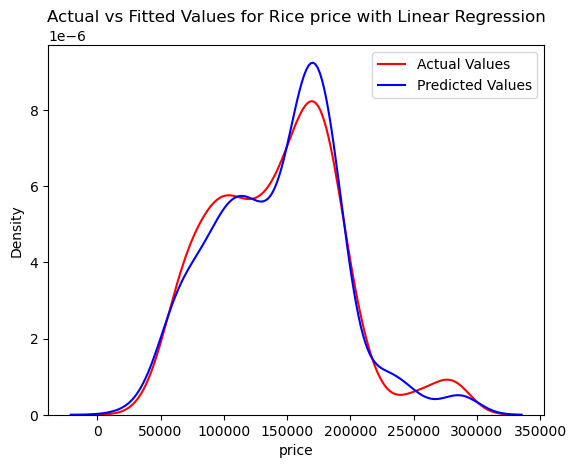

Training Model: Decision Tree:   0%|          | 0/1 [00:00<?, ?it/s]

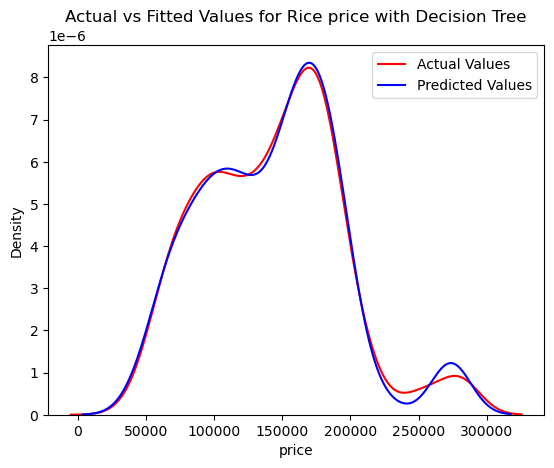

Training Model: Random Forest:   0%|          | 0/1 [00:00<?, ?it/s]

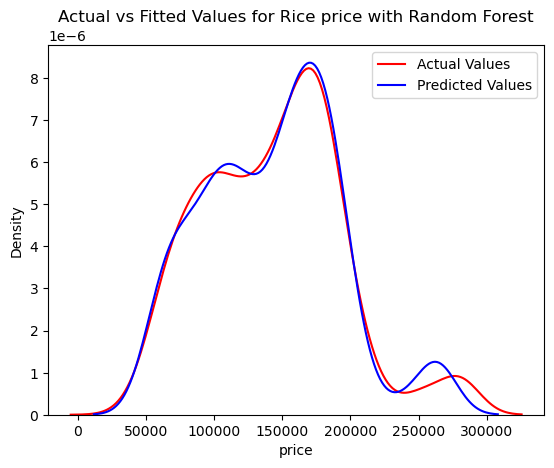

Training Model: KNN Regressor:   0%|          | 0/1 [00:00<?, ?it/s]

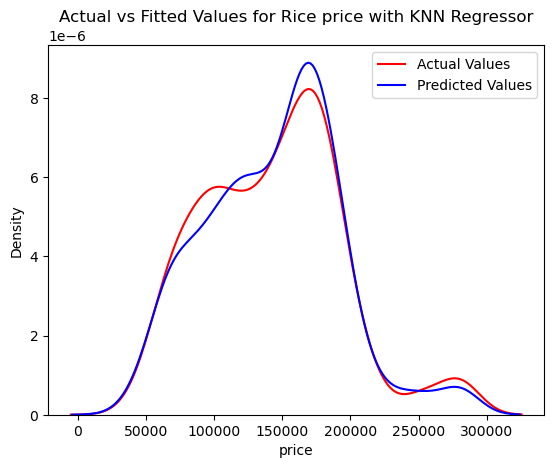

Training Model: Gradient Boosting:   0%|          | 0/1 [00:00<?, ?it/s]

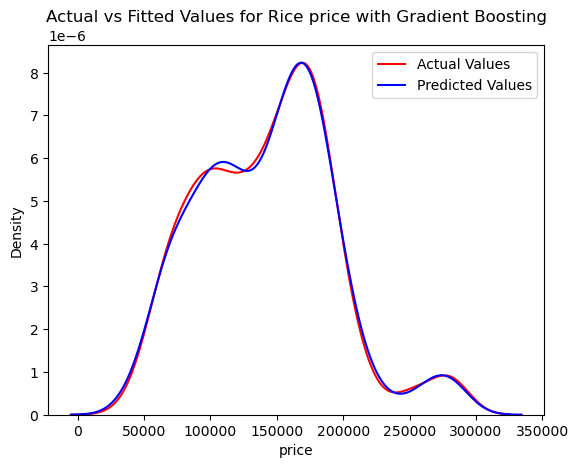

Training Model: XGBoost Regressor:   0%|          | 0/1 [00:00<?, ?it/s]

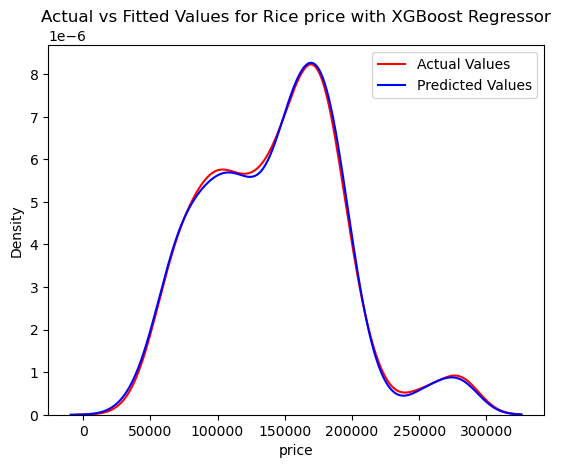

Training Model: LightGBM Regressor:   0%|          | 0/1 [00:00<?, ?it/s]

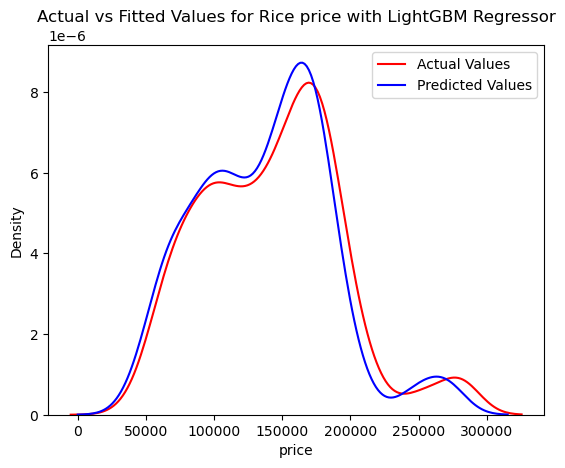

Training Model: CatBoost Regressor:   0%|          | 0/1 [00:00<?, ?it/s]

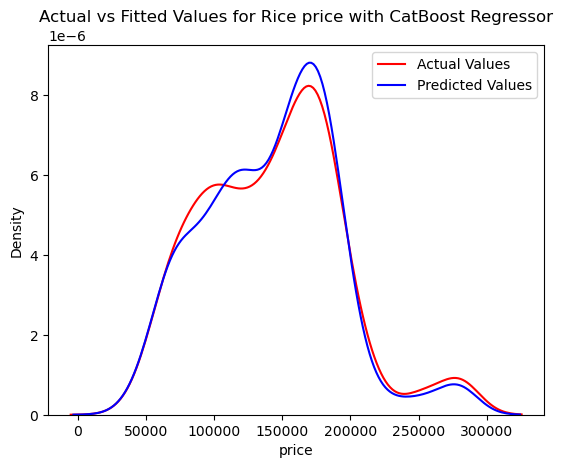

,Model Name,MAE,MSE,RMSE,R^2
0,Linear Regression,12001.569432,2.884887e+08,16984.954221,88.8282%
1,Decision Tree,5954.318336,9.260836e+07,9623.323536,96.4137%
2,Random Forest,5619.846243,9.249302e+07,9617.329103,96.4182%
3,KNN Regressor,12450.873918,3.402783e+08,18446.633931,86.8226%
4,Gradient Boosting,5897.673515,1.196603e+08,10938.935678,95.3661%
5,XGBoost Regressor,5069.801056,8.587860e+07,9267.070869,96.6743%
6,LightGBM Regressor,7268.150150,1.181650e+08,10870.373561,95.4240%
7,CatBoost Regressor,6412.445152,1.301082e+08,11406.499923,94.9615%


In [21]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(max_depth=1000, random_state=42, min_samples_leaf=30, min_samples_split=50),
    'Random Forest': RandomForestRegressor(max_depth=1000, n_estimators=1000, random_state=42, min_samples_leaf=30, min_samples_split=50),
    'KNN Regressor': KNeighborsRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=1000,
        max_depth=1000,
        learning_rate=0.2,
        min_samples_leaf=30,
        min_samples_split=10
    ),
    'XGBoost Regressor': XGBRegressor(n_estimators=1000, max_depth=1000, learning_rate=0.2),
    'LightGBM Regressor': lgb.LGBMRegressor(
        objective='regression',
        metric='mse',
        feature_fraction=0.8,
        bagging_fraction=0.8,
        bagging_freq=5,
        verbose=0,
        boosting_type='dart',
        learning_rate=0.2,
        n_estimators=100,
        num_leaves=30,
        max_depth=1000,
        verbosity=-1,
        silent=True
    ),
    'CatBoost Regressor': CatBoostRegressor(n_estimators=1000, max_depth=16, logging_level='Silent', learning_rate=0.2),
}

results = {
    'Model Name': [],
    'MAE': [],
    'MSE': [],
    'RMSE': [],
    'R^2': []
}

param_grids = {
    'Linear Regression': {
        'fit_intercept': [True, False],
        'copy_X': [True, False],
        'n_jobs': [10, 20, 60, 80, 100],
        'positive': [True, False]
    },
    'Random Forest': {
        'bootstrap': [True, False],
    },
    'KNN Regressor': {
        'n_neighbors': [1, 3, 5, 10, 20],
        'weights': ['uniform', 'distance'],
        'p': [1, 2],
    }
}

best_models = {}

tuneBar = tqdm(models.items(), desc="Tuning Models")

for name, model in tuneBar:
    if name in param_grids:
        param_grid = param_grids[name]
        with tqdm(total=1, desc=f"Tuning Model: {name}") as insideBar:
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                                       scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
            grid_search.fit(feature_train, target_train)
            insideBar.update(1)
        best_model = grid_search.best_estimator_
        best_models[name] = best_model
    else:
        best_models[name] = model


trainBar = tqdm(models.items(), desc="Training Models")

for name, model in trainBar:
    with tqdm(total=1, desc=f"Training Model: {name}") as insideBar:
        model.fit(feature_train, target_train)
        pickle.dump(model, open(
            f'../../Models/Rice/Rice_model_{name}.pkl', 'wb'))
        model = pickle.load(
            open(f'../../Models/Rice/Rice_model_{name}.pkl', 'rb'))
        predictions = model.predict(feature_test)
        insideBar.update(1)

    mae = mean_absolute_error(target_test, predictions)
    mse = mean_squared_error(target_test, predictions)
    rmse = mean_squared_error(target_test, predictions, squared=False)
    r2 = r2_score(target_test, predictions)

    results['Model Name'].append(name)
    results['MAE'].append(mae)
    results['MSE'].append(mse)
    results['RMSE'].append(rmse)
    results['R^2'].append(f'{r2 * 100:.4f}%')

    ax1 = sns.distplot(target_test, hist=False,
                       color="r", label="Actual Values")
    sns.distplot(predictions, hist=False, color="b",
                 label="Predicted Values", ax=ax1)
    plt.title(f'Actual vs Fitted Values for Rice price with {name}')
    plt.legend()
    plt.show()
    print()
    plt.close()

results = pd.DataFrame(results)
results
